In [24]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import keras.optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import callbacks

In [2]:
# no of rows that are removed from the dataset because 6th row wasn't their for that particular plane
rows_removed = 0  

#convert an array of calues into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    global rows_removed
    for i in range(len(dataset) - look_back-1):
        if (dataset[i + look_back][0] != dataset[i][0]):
            rows_removed = rows_removed + 1
            continue
        a = dataset[i:(i + look_back), 1]
        dataX.append(a)
        dataY.append([dataset[i + look_back, 1]])
    return np.array(dataX), np.array(dataY)

In [3]:
#fix random seed for reproducibility
np.random.seed(7)

In [4]:
from google.colab import files
uploaded = files.upload()

Saving new planes.csv to new planes.csv


In [5]:
#load the dataset
dataframe = read_csv("new planes.csv", usecols=[0, 2], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

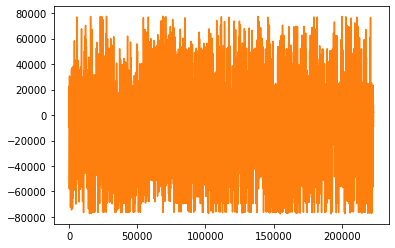

In [37]:
plt.plot(dataset)
plt.show()

In [6]:
#split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

#reshape into X=t and Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

#print(rows_removed)
# print sample data
for i in range(0, 5):
  print(trainX[i], trainY[i])

#reshape input to be[ samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

[-9455. -9255. -9055. -8853. -8651.] [-8445.]
[-9255. -9055. -8853. -8651. -8445.] [-8231.]
[-9055. -8853. -8651. -8445. -8231.] [-8014.]
[-8853. -8651. -8445. -8231. -8014.] [-7800.]
[-8651. -8445. -8231. -8014. -7800.] [-7585.]


In [34]:
#create and fit the LSTM Network
n_steps = 5
n_features = 1
batch_size = 1
# define model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')
model.fit(trainX, trainY, epochs=30, verbose=2, validation_data = (testX, testY), callbacks = callbacks.EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True))

Epoch 1/30
4511/4511 - 29s - loss: 5078946.5000 - val_loss: 17396.0586
Epoch 2/30
4511/4511 - 24s - loss: 77166.8516 - val_loss: 7162.6748
Epoch 3/30
4511/4511 - 23s - loss: 704950.1875 - val_loss: 257667.7656
Epoch 4/30
4511/4511 - 24s - loss: 123182.7188 - val_loss: 6651.1934
Epoch 5/30
4511/4511 - 23s - loss: 32678.8281 - val_loss: 5171.8853
Epoch 6/30
4511/4511 - 23s - loss: 244553.0312 - val_loss: 39258.5039
Epoch 7/30
4511/4511 - 22s - loss: 26822.0840 - val_loss: 10699.1465
Epoch 8/30
4511/4511 - 23s - loss: 34953.4414 - val_loss: 6412.4043


In [35]:
#make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
#model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

Train Score: 69.88 RMSE
Test Score: 71.92 RMSE


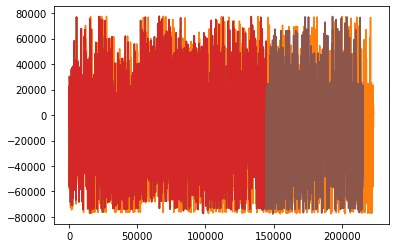

In [36]:
#calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:], trainPredict[:,0]))
print("Train Score: %.2f RMSE" % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:], testPredict[:,0]))
print("Test Score: %.2f RMSE" % (testScore))


#shift train predictions for plotting 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

#shift test predictions for plottting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1: len(dataset)-1 - rows_removed, :] = testPredict

#plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [39]:
# demonstrate prediction
x_input = np.array([5000, 6000, 7800, 9200, 10000])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[11733.006]]


In [ ]:
# how to do decide lstm units (no of hidden units whose activation get sent forward to the next layer)